<a href="https://colab.research.google.com/github/anhhaibkhn/ocr-opencv-python-tutorials/blob/main/opencv_review/opencv_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd drive/MyDrive/opencv_review/

/content/drive/MyDrive/opencv_review


In [1]:
import cv2, os
from imutils import paths
import numpy as np
from pathlib import Path


base_path = "imgs"
new_path = "jpgs/"


class Error(Exception):
    def __init__(self, message):
        self.message = message

class ImageReadError(Error):
    """ imread error
    """
class ImageWriteError(Error):
    """ imwrite error
    """

def imread(filepath, flags=cv2.IMREAD_COLOR):
    """ Read image from file path - supported utf 8"""
    try:
        n = np.fromfile(str(filepath), np.uint8)
        img = cv2.imdecode(n, flags)
        return img
    except Exception as e:
        raise ImageReadError('イメージを読み込めません: {}, {}'.format(filepath, e))


def imwrite(filepath, img, SHOW_IMG = False):
    """ Write image to file path - supported utf 8"""
    try:
        ext = '.jpg'
        result, n = cv2.imencode(ext, img)

        # showing step by step how the image was processed
        if SHOW_IMG: show_img_from_ndarray(os.path.splitext(os.path.basename(filepath))[0],img, n)
        if result:
            with open(filepath, 'w+b') as fp:
                n.tofile(fp)
        else:
            raise ImageWriteError('イメージを書き込めません: {}'.format(filepath))
    except Exception as e:
        raise ImageWriteError('イメージを書き込めません: {}, {}'.format(filepath, e))


def show_img_from_ndarray(basename_without_ext , img ,n):
    """ Displaying picture from np.ndarray 
    @para:
        filepath: image saving file_name
        img: the original image data as 2D or 3D numpy array
        n: the image data after cv2.imencode
    
    @ return: Nothing
    """
    print("raw ",type(img),img.shape)
    print("after imencode ",type(n),n.shape)
    # the following comment code is to display with PIL 
    # # PIL can not show from such array with shape M x N x 1 -> reshape to M x N. 
    # if len(img.shape) > 2 and img.shape[-1] == 1:
    #     img = img.reshape(img.shape[0], img.shape[1])
    # new_img  = Image.fromarray(img)
    # new_img.show()
    # new_img.close()
    # time.sleep(5)

    new_img = cv2.imdecode(n, cv2.IMREAD_COLOR)
    cv2.imshow( basename_without_ext ,new_img)
    cv2.waitKey(0)



def convert_to_jpgs(base_path):
    """ Convert all files in a target folder into jpg format """
    for imagePath in paths.list_images(base_path):
        read = imread(imagePath)
        print(read.shape)
        # cv2.imshow("title", read)
        # cv2.waitKey(0)
        outfile = new_path + Path(imagePath).with_suffix('.jpg').name
        
        if not os.path.exists(new_path):
            print("create upload folder=%s", new_path)
            os.mkdir(new_path)
        
        print(outfile)
        imwrite(outfile ,read)

def find_tables(image):
    BLUR_KERNEL_SIZE = (17, 17)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv2.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, vertical_kernel)
    
    horizontally_dilated = cv2.dilate(horizontally_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1)))
    vertically_dilated = cv2.dilate(vertically_opened, cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60)))
    
    mask = horizontally_dilated + vertically_dilated
    contours, heirarchy = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE,
    )

    MIN_TABLE_AREA = 1e5
    contours = [c for c in contours if cv2.contourArea(c) > MIN_TABLE_AREA]
    perimeter_lengths = [cv2.arcLength(c, True) for c in contours]
    epsilons = [0.1 * p for p in perimeter_lengths]
    approx_polys = [cv2.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    bounding_rects = [cv2.boundingRect(a) for a in approx_polys]

    # The link where a lot of this code was borrowed from recommends an
    # additional step to check the number of "joints" inside this bounding rectangle.
    # A table should have a lot of intersections. We might have a rectangular image
    # here though which would only have 4 intersections, 1 at each corner.
    # Leaving that step as a future TODO if it is ever necessary.
    images = [image[y:y+h, x:x+w] for x, y, w, h in bounding_rects]
    return images



In [ ]:
# Converting directly 1 tif file to jpg
read = imread("29_contrast_s_img.tif")
imwrite("29_contrast_s_img.jpg" ,read)

In [ ]:
import cv2

image_filename = "29_contrast_s_img.jpg"
image = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)
image_list = find_tables(image)

print(len(image_list))
for i, image in enumerate(image_list):
    cv2.imwrite('example_table_{}.png'.format(i), image)


1


In [ ]:
import pprint
# text_block_img is grayscale, but when saving it becomes BGR 
text_block_img = cv2.imread('imgs/92_contour_rect_h_close.tif', cv2.IMREAD_GRAYSCALE)

print("text_block_img :", text_block_img.shape)
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(text_block_img)

print("retval :", retval) 
print("labels :", labels)
print("stats :", stats.shape)
pprint.pprint(stats)
print("centroids :", centroids.shape)
pprint.pprint(centroids)

block_mean_width = np.mean(stats[1:, cv2.CC_STAT_WIDTH])
block_mean_height = np.mean(stats[1:, cv2.CC_STAT_HEIGHT])

print("block_mean_width",  block_mean_width)
print("block_mean_height",  block_mean_height)

text_block_img : (3508, 2480)
retval : 853
labels : [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
stats : (853, 5)
array([[      0,       0,    2480,    3508, 7906408],
       [   1308,      25,      58,      22,     942],
       [   1374,      26,      69,      33,    1982],
       ...,
       [   2378,    3427,      15,      27,     405],
       [   2398,    3428,      23,      26,     322],
       [   2212,    3438,      25,      16,     400]], dtype=int32)
centroids : (853, 2)
array([[1251.26810468, 1810.65013366],
       [1337.87154989,   37.54352442],
       [1411.52421796,   42.06155399],
       ...,
       [2385.        , 3440.        ],
       [2406.67701863, 3442.20186335],
       [2224.        , 3445.5       ]])
block_mean_width 32.46478873239437
block_mean_height 25.937793427230048


In [ ]:
def left(s): return s[cv2.CC_STAT_LEFT]

# def is_in_table( stat):

#     x1 = self.left(stat)
#     y1 = self.top(stat)
#     x2 = x1 + self.width(stat)
#     y2 = y1 + self.height(stat)

#     for tbl in self.tables:
#         x, y, w, h = tbl.rect
#         if x1 >= x and y1 >= y and x2 <= x + w and y2 <= y + h:
#             return tbl.id

#     return None

text_blocks = []
text_blocks_in_table = {}
for (s, c) in zip(stats[1:], centroids[1:]):
    text_blocks.append([s, c, 0])
    
    # id = is_in_table(s)
    # if id is not None:
    #     if id not in text_blocks_in_table:
    #         text_blocks_in_table[id] = []
    #     text_blocks_in_table[id].append([s, c, 0])
    # else:
    #     text_blocks.append([s, c, 0])

pprint.pprint( text_blocks[:5]) 


[[array([1308,   25,   58,   22,  942], dtype=int32),
  array([1337.87154989,   37.54352442]),
  0],
 [array([1374,   26,   69,   33, 1982], dtype=int32),
  array([1411.52421796,   42.06155399]),
  0],
 [array([1535,   26,   68,   29, 1783], dtype=int32),
  array([1571.62703309,   40.10095345]),
  0],
 [array([1139,   29,   55,   65, 3575], dtype=int32), array([1166.,   61.]), 0],
 [array([1455,   28,   68,   67, 4556], dtype=int32),
  array([1488.5,   61. ]),
  0]]


In [ ]:
# table 外の text block を sort 
x_sorted = sorted(text_blocks[:5], key=lambda x: x[0][cv2.CC_STAT_LEFT])
pprint.pprint(x_sorted[:5])
print("===========")
text_blocks = sorted(x_sorted, key=lambda x: x[0][cv2.CC_STAT_TOP ])
pprint.pprint(text_blocks[:5])

[[array([1139,   29,   55,   65, 3575], dtype=int32), array([1166.,   61.]), 0],
 [array([1308,   25,   58,   22,  942], dtype=int32),
  array([1337.87154989,   37.54352442]),
  0],
 [array([1374,   26,   69,   33, 1982], dtype=int32),
  array([1411.52421796,   42.06155399]),
  0],
 [array([1455,   28,   68,   67, 4556], dtype=int32),
  array([1488.5,   61. ]),
  0],
 [array([1535,   26,   68,   29, 1783], dtype=int32),
  array([1571.62703309,   40.10095345]),
  0]]
[[array([1308,   25,   58,   22,  942], dtype=int32),
  array([1337.87154989,   37.54352442]),
  0],
 [array([1374,   26,   69,   33, 1982], dtype=int32),
  array([1411.52421796,   42.06155399]),
  0],
 [array([1535,   26,   68,   29, 1783], dtype=int32),
  array([1571.62703309,   40.10095345]),
  0],
 [array([1455,   28,   68,   67, 4556], dtype=int32),
  array([1488.5,   61. ]),
  0],
 [array([1139,   29,   55,   65, 3575], dtype=int32), array([1166.,   61.]), 0]]


In [ ]:
""" Mutable and Immutable Data Types """
# https://www.dataquest.io/blog/tutorial-functions-modify-lists-dictionaries-python/

class first():
    def __init__(self):
        pass
    
    def fun_1(self, dic, lst):
        for k, v in dic.items():
            dic[k] = v + v
        dic["new"] = 10
        
        for i in lst:
            i[1] = i[1] * 2
    

    def fun_2(self):
        content_ratings = {'4+': 4433, '9+': 987, '12+': 1155, '17+': 622}
        initial_list = [[1,1],[2,2],[3,3]]

        self.fun_1(content_ratings, initial_list)

        print(content_ratings, initial_list)
        " the contents are changed "
        debug = False
        if debug:
            new_d = {}

        new_d["k"] = 15

    
fst = first()
fst.fun_2()



(3508, 2480, 3) (3508, 2480)
6543
8693850.0
aaaa
2.0
2.0
4.0
2.0
2.0
2.0
2.0
2.0
4.0


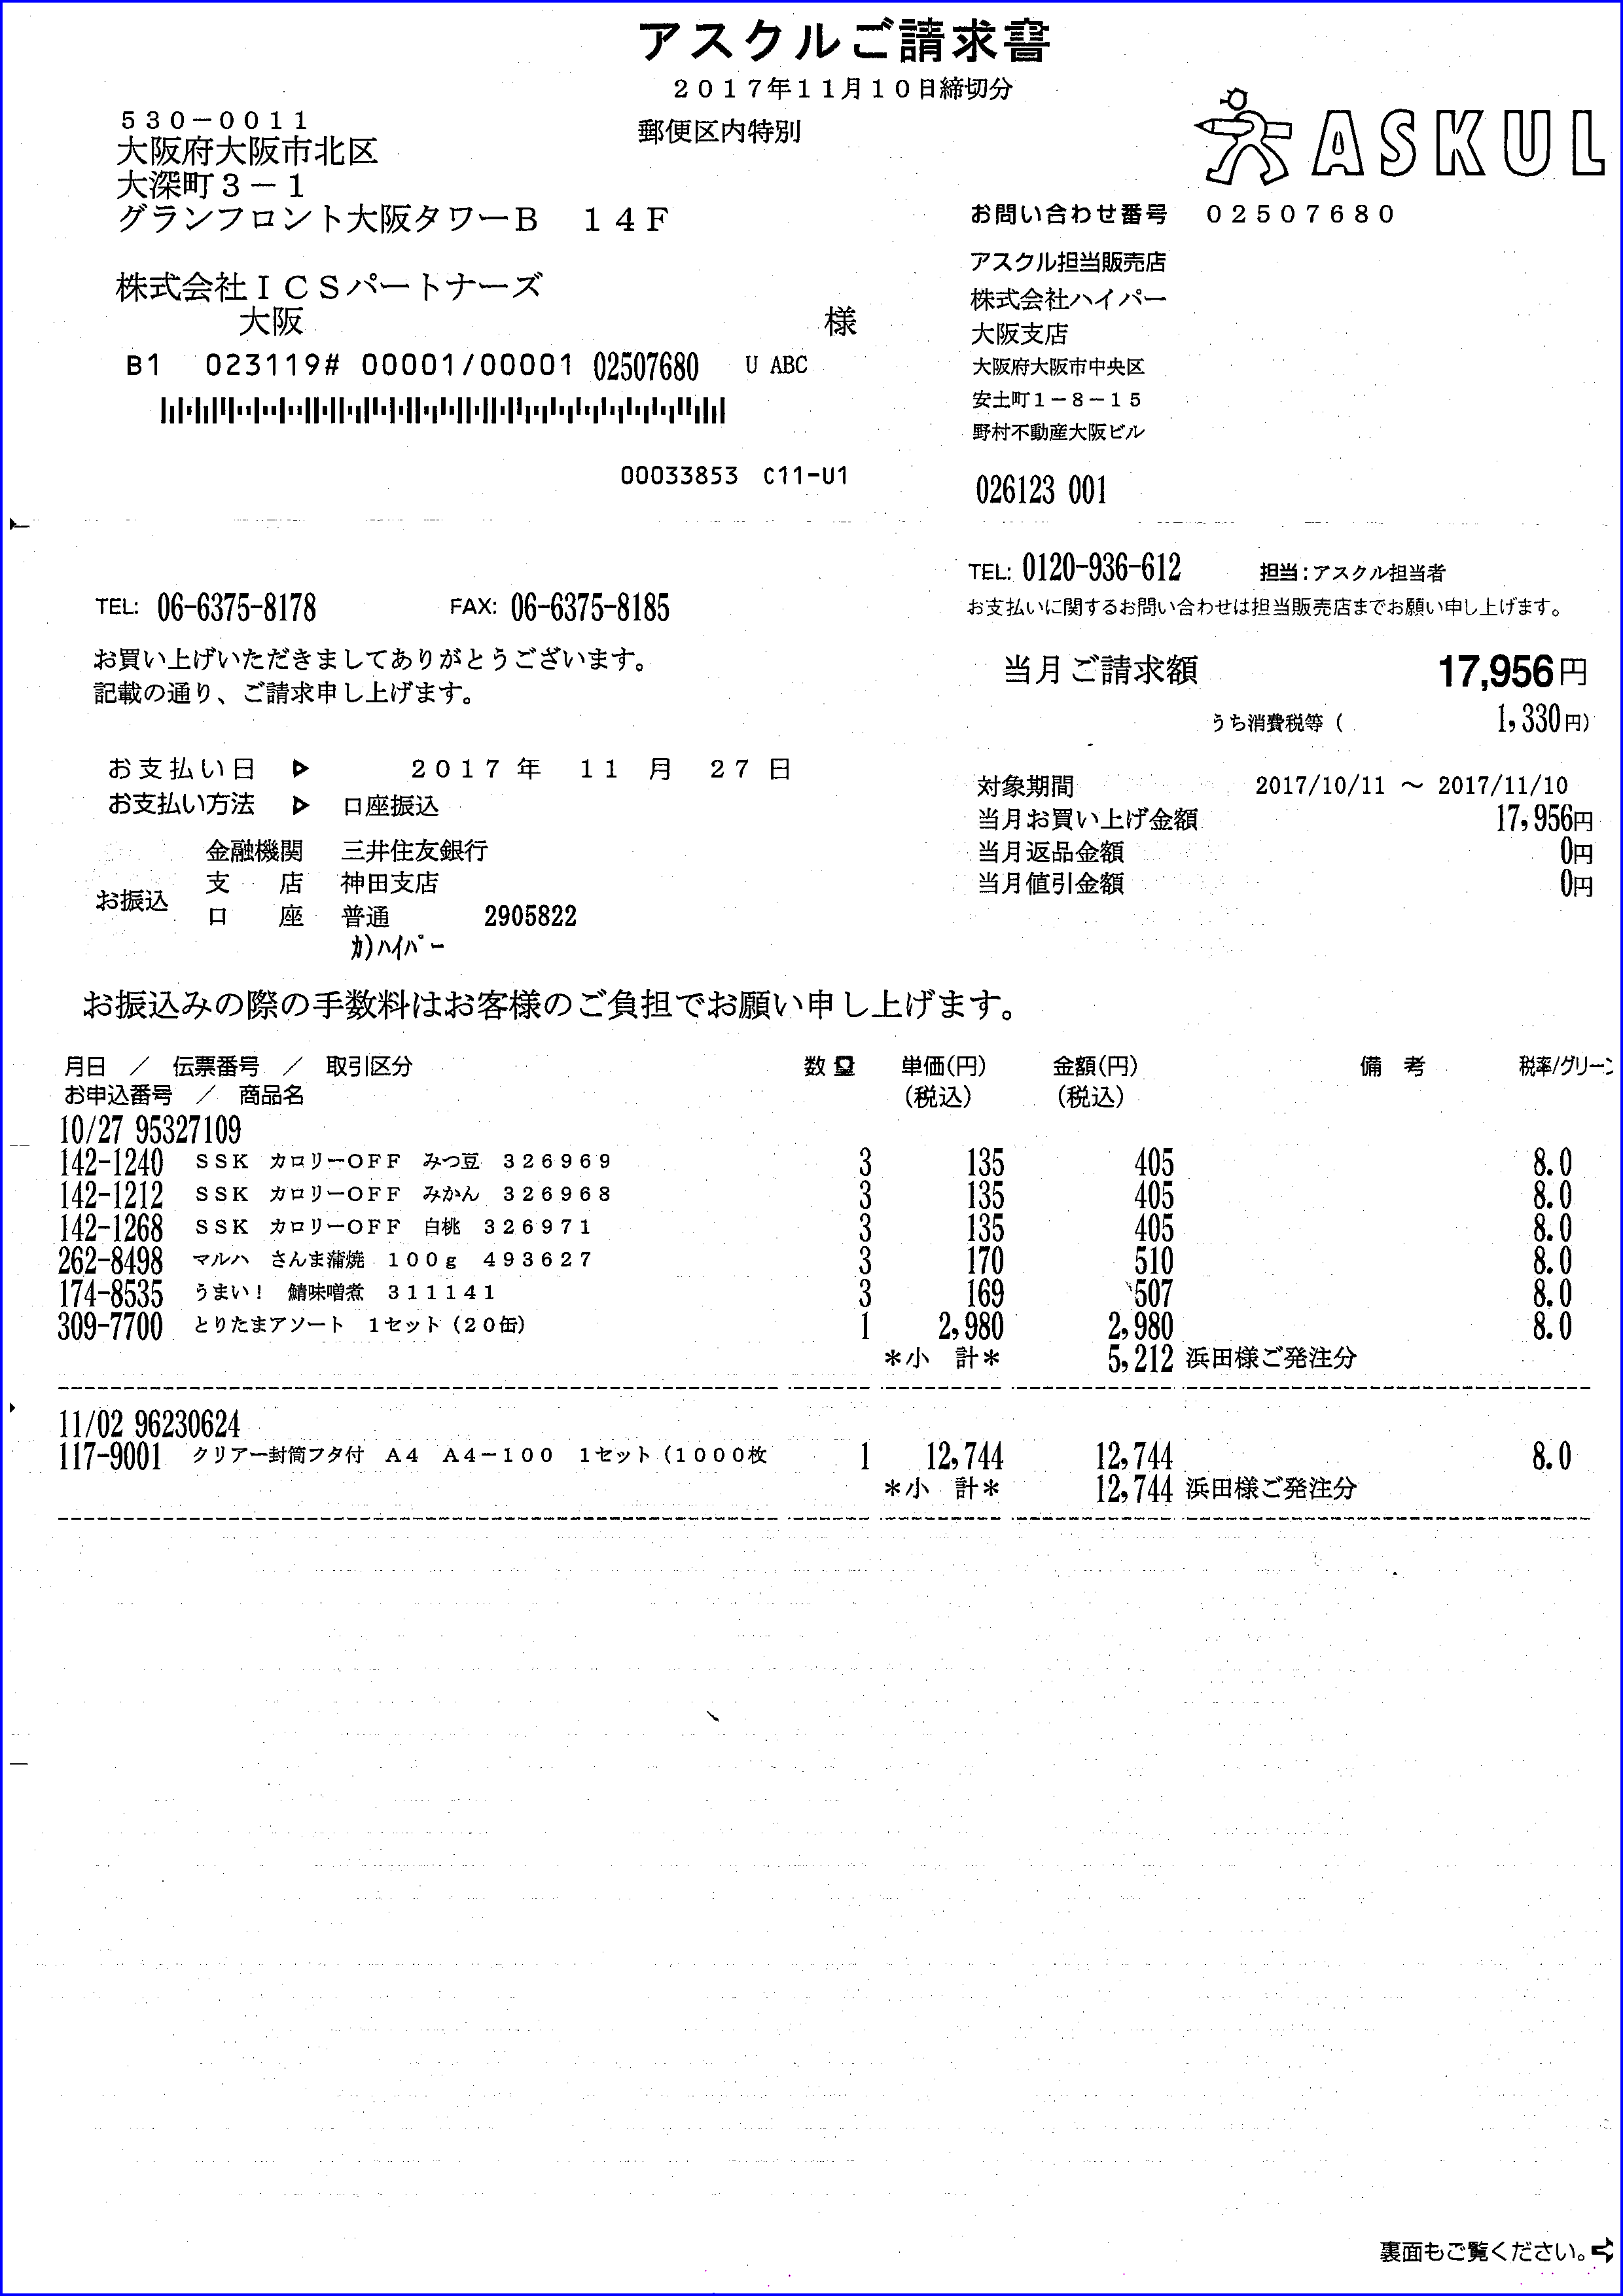

In [32]:
from google.colab.patches import cv2_imshow
import pprint as p
# Converting directly 1 tif file to jpg (BGR ----> 255,0,0 = BLUE)
bin_img = cv2.imread('/content/89_detector_org.tif', cv2.COLOR_GRAY2BGR)
d_img  = cv2.cvtColor(bin_img, cv2.COLOR_GRAY2BGR)

# shape (3508, 2480)
print(d_img.shape, bin_img.shape)
img_h, img_w = bin_img.shape

contours, hierarchy = cv2.findContours(bin_img , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

print(len(contours))

for cont in contours[:10]:
    area = cv2.contourArea(cont)
    print(area)
    if area <= 30: 
        cv2.drawContours(d_img, [cont], 0, (255,0,255), 1) # put Blue
    elif area > 5000:
        cv2.drawContours(d_img, [cont], 0, (255,0,0), 5) # put RED
        print("aaaa")
    else:
        cv2.drawContours(d_img, [cont], 0, (0,255,0), 1) # put Green
        


cv2_imshow(d_img)
